In [7]:
import os
import sys
from importlib import reload
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import pandas as pd

from icecream import ic, colorize as ic_colorize, argumentToString

sns.set_style('white')
sns.set_theme(rc={"legend.facecolor": "w"})

mpl.rcParams["pdf.fonttype"] = 42

os.environ["PYDEVD_DISABLE_FILE_VALIDATION"] = "1"

# Register a function to summarize numpy array
@argumentToString.register
def argumentToString_ndarray(obj: np.ndarray):
  return (
    f"ndarray, shape={obj.shape}, dtype={obj.dtype}, "
    f"min={obj.min()}, max={obj.max()}"
  )


ic.configureOutput(prefix="⚡ ")
ic.configureOutput(outputFunction=lambda s: print(ic_colorize(s)))

np.set_printoptions(threshold=5, precision=2, edgeitems=2, linewidth=200, suppress=True)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from admice.dataload import session_from_mouse_from_matfile, load_mice_from_mat 

In [9]:
data_root = os.path.expanduser("~/data/tedho_ad_mice/")

def jdr(fname:str) -> str:
  return os.path.join(data_root, fname)

sess_ctrl = load_mice_from_mat(jdr("workspace_28-Jun-2024_control_mice_2p_data_for_dan.v7.mat"), "controlmice", "control")
sess_young = load_mice_from_mat(jdr("workspace_28-Jun-2024_young3xtg_mice_2p_data_for_dan.v7.mat"), "young3xtgmice", "young_3xtg")
sess_old = load_mice_from_mat(jdr("workspace_28-Jun-2024_old3xtg_mice_2p_data_for_dan.v7.mat"), "old3xtgmice", "old_3xtg")

bad_mouse_ids = [16, 22, 52]

# filter out 3 bad mice Ted mentioned in Slack
sess_young = [mouse for mouse in sess_young if mouse.mouse_id not in bad_mouse_ids]
sess_old = [mouse for mouse in sess_old if mouse.mouse_id not in bad_mouse_ids]

ic([mouse.mouse_id for mouse in sess_ctrl]);
ic([mouse.mouse_id for mouse in sess_young]);
ic([mouse.mouse_id for mouse in sess_old]);

⚡ [mouse.mouse_id for mouse in sess_ctrl]: [27, 15, 17, 25, 33, 34, 35]
⚡ [mouse.mouse_id for mouse in sess_young]: [18, 19, 20, 23, 24]
⚡ [mouse.mouse_id for mouse in sess_old]: [28, 29, 30, 31, 32]


# LDA projections

from 06\_ notebook: v5 - cross-validated on whole trial


## rerunning to generate picked results


In [4]:
from admice.eventlda import FilteringStrategy, NeuronSamplingStrategy

filt_strat_fit = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23, window_buffer_pre = 4, reduce_mode_pre = "mean", 
  window_width_post = 4, window_buffer_post = 0, reduce_mode_post = "mean")
filt_strat_project = filt_strat_fit
samp_strat = NeuronSamplingStrategy(mode="random", n_neurons = 50)

n_samples = 100

In [ ]:
# run on all ctrl mice
from admice.ldaproj import multimouse_pipeline_project_wholetrial_lda_pufftone 

n_samples = 100
lda_mode = "separate_cv"
proj_res_ctrl = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_ctrl, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, lda_mode = lda_mode, samp_strat=samp_strat, n_samples = n_samples)
proj_res_young = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_young, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, lda_mode = lda_mode, samp_strat=samp_strat, n_samples = n_samples)
proj_res_old = multimouse_pipeline_project_wholetrial_lda_pufftone(sess_old, 
  filt_strat_fit=filt_strat_fit, filt_strat_project=filt_strat_project, lda_mode = lda_mode, samp_strat=samp_strat, n_samples = n_samples)


In [ ]:
import pickle

analysis_root = os.path.join(data_root, "analysis")
if not os.path.exists(analysis_root):
  os.mkdir(analysis_root)

with open(os.path.join(analysis_root, 'lda_projection_wholetrial_separate_cv.pkl'), 'wb') as file:
  pickle.dump({'ctrl': proj_res_ctrl, 'young': proj_res_young, 'old': proj_res_old}, file)

## plotting loaded from pickle data


In [33]:
import pickle

analysis_root = os.path.join(data_root, "analysis")
with open(os.path.join(analysis_root, 'lda_projection_wholetrial_separate_cv.pkl'), 'rb') as file:
  ld = pickle.load(file)

proj_res_ctrl = ld['ctrl']
proj_res_young = ld['young']
proj_res_old = ld['old']


In [34]:
import matplotlib.ticker as ticker

from admice.dataload import Session
from admice.ldaproj import LDAProjResults

sns.set_style("ticks")

def plot_traj(mice: list[Session], res: LDAProjResults, ax, show_mean: bool = True, show_indiv: bool = False):
  sess = mice[0]
  offset = -filt_strat_project.window_width_post - filt_strat_project.window_buffer_post - 1

  tone_ind = sess.tone_ind + offset
  start_ind = tone_ind - sess.fps
  puff_ind = sess.puff_ind + offset


  if show_indiv:
    alpha_indiv = 0.4
    lw_indiv = 1
    proj_stk, time_vec = res.get_avg_stk(omitnan=True)
    proj_stk -= np.nanmean(proj_stk[:, start_ind:tone_ind, :], axis=1, keepdims=True)
    end_ind = min(proj_stk.shape[1], puff_ind + int(1.0 * sess.fps))
    S = len(mice)
    
    for s in range(S):
      ax.plot(*proj_stk[s, start_ind:tone_ind+1, :].T, color='k', alpha=alpha_indiv, linewidth=lw_indiv)
      ax.plot(*proj_stk[s, tone_ind:puff_ind+1, :].T, color='g', alpha=alpha_indiv, linewidth=lw_indiv)
      ax.plot(*proj_stk[s, puff_ind:end_ind, :].T, color='r', alpha=alpha_indiv*0.7, linewidth=lw_indiv)

  if show_mean:
    lw_mean = 2.5
    proj_tk, time_vec = res.get_grand_avg_tk(omitnan=True)
    proj_tk -= np.nanmean(proj_tk[start_ind:tone_ind], axis=0, keepdims=True)
    end_ind = min(proj_tk.shape[0], puff_ind + int(1.5 * sess.fps))
    
    ax.plot(*proj_tk[start_ind:tone_ind+1, :].T, color='k', linewidth=lw_mean)
    ax.plot(*proj_tk[tone_ind:puff_ind+1, :].T, color='g', linewidth=lw_mean)
    ax.plot(*proj_tk[puff_ind:end_ind, :].T, color='r', linewidth=lw_mean)

    ax.plot(*proj_tk[start_ind, :], marker='o', color='k')
    ax.plot(*proj_tk[tone_ind, :], marker='o', color='g')
    ax.plot(*proj_tk[puff_ind, :], marker='o', color='r')

  ax.set_title(sess.group)
  ax.set_aspect(1)

/Users/djoshea/Dropbox/Dlab/Ted Ho AD Mouse Project/tedho_ad_mice/admice/ldaproj.py:668: RuntimeWarning: Mean of empty slice
  proj_s_crtk = [mean(a_crtk, axis=tuple(axes_avg), keepdims=True) for a_crtk in self.proj_s_crtk]


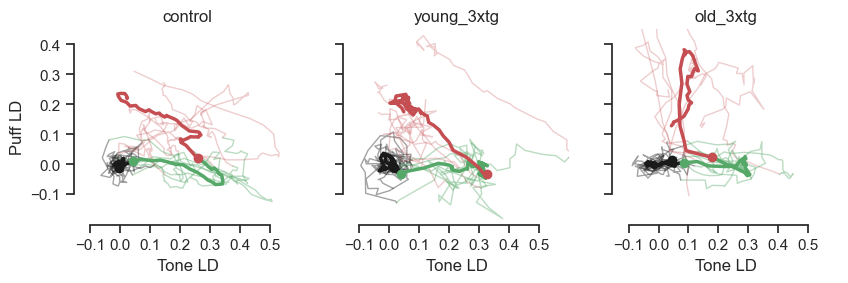

In [35]:
sns.set_style("ticks")
show_indiv = True
show_mean = True 
fig, ax = plt.subplots(1, 3, figsize=np.array((25, 8)) / 2.54, sharex=True, sharey=True)
plot_traj(sess_ctrl, proj_res_ctrl, ax[0], show_indiv=show_indiv, show_mean=show_mean)
ax[0].set_ylabel('Puff LD')
ax[0].set_xlabel('Tone LD')

plot_traj(sess_young, proj_res_young, ax[1], show_indiv=show_indiv, show_mean=show_mean)
ax[1].set_xlabel('Tone LD')

plot_traj(sess_old, proj_res_old, ax[2], show_indiv=show_indiv, show_mean=show_mean)
ax[2].set_xlabel('Tone LD');

ax[0].set_xlim([-0.15, 0.6]);
ax[0].set_ylim([-0.2, 0.45]);
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

sns.despine(fig, offset=1, trim=True)

plt.savefig('../figures/lda_trajectories.pdf', facecolor='w')
  

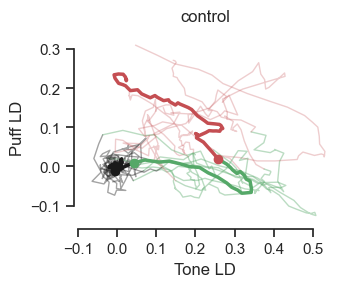

In [36]:
sns.set_style("ticks")
show_indiv = True
show_mean = True 
fig, ax = plt.subplots(1, 1, figsize=np.array((25/3, 8)) / 2.54, sharex=True, sharey=True)
plot_traj(sess_ctrl, proj_res_ctrl, ax, show_indiv=show_indiv, show_mean=show_mean)
ax.set_ylabel('Puff LD')
ax.set_xlabel('Tone LD')

ax.set_xlim([-0.1, 0.55]);
ax.set_ylim([-0.15, 0.35]);
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

sns.despine(fig, offset=3, trim=True)

plt.savefig('../figures/lda_traj_ctrl.pdf', facecolor='w')
  

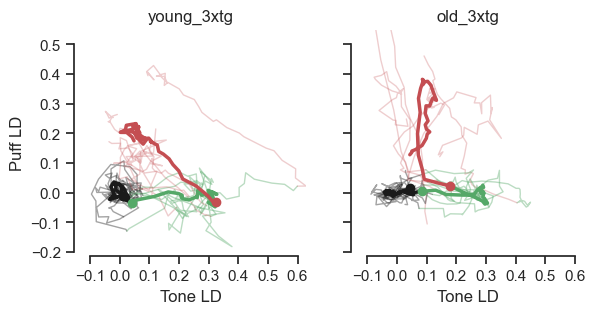

In [37]:
sns.set_style("ticks")
show_indiv = True
show_mean = True 

fig, ax = plt.subplots(1, 2, figsize=np.array((25.*2./3., 8)) / 2.54, sharex=True, sharey=True)
plot_traj(sess_young, proj_res_young, ax[0], show_indiv=show_indiv, show_mean=show_mean)
ax[0].set_ylabel('Puff LD')
ax[0].set_xlabel('Tone LD')

plot_traj(sess_old, proj_res_old, ax[1], show_indiv=show_indiv, show_mean=show_mean)
ax[1].set_xlabel('Tone LD');

ax[0].set_xlim([-0.15, 0.63]);
ax[0].set_ylim([-0.21, 0.55]);
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(0.1))
ax[0].yaxis.set_major_locator(ticker.MultipleLocator(0.1))

sns.despine(fig, offset=1, trim=True)

plt.savefig('../figures/lda_traj_young_old.pdf', facecolor='w')
  

# LDA accuracy vs time

from 05 sliding notebook


## re-running if not loading picked data


In [27]:
from admice.eventlda import FilteringStrategy, NeuronSamplingStrategy

filt_strat = FilteringStrategy(mode="two_window_delta", 
  window_width_pre = 23,
  window_buffer_pre = 4, 
  reduce_mode_pre = "mean",
  window_width_post= 3,
  window_buffer_post = 0, 
  reduce_mode_post = "max" 
)

samp_strat = NeuronSamplingStrategy(mode="random", n_neurons = 50)

In [ ]:
from admice.eventlda_sliding import multimouse_pipeline_lda_sliding

n_samples = 1000
time_range_rel_tone = [-31, 62]

sliding_res_ctrl = multimouse_pipeline_lda_sliding(
  sess_ctrl,
  filt_strat,
  samp_strat,
  time_range_rel_tone = time_range_rel_tone,
  n_samples = n_samples,
  n_batches = 8,
)

sliding_res_young = multimouse_pipeline_lda_sliding(
  sess_young,
  filt_strat,
  samp_strat,
  time_range_rel_tone = time_range_rel_tone,
  n_samples = n_samples,
  n_batches = 8,
)

sliding_res_old = multimouse_pipeline_lda_sliding(
  sess_old,
  filt_strat,
  samp_strat,
  time_range_rel_tone = time_range_rel_tone,
  n_samples = n_samples,
  n_batches = 8,
)

In [ ]:
import pickle

analysis_root = os.path.join(data_root, "analysis")
if not os.path.exists(analysis_root):
  os.mkdir(analysis_root)

with open(os.path.join(analysis_root, 'lda_sliding_samples.pkl'), 'wb') as file:
  pickle.dump({'ctrl': sliding_res_ctrl, 'young': sliding_res_young, 'old': sliding_res_old}, file)

## plotting loaded from pickle data


In [16]:
import pickle

analysis_root = os.path.join(data_root, "analysis")
with open(os.path.join(analysis_root, 'lda_sliding_samples.pkl'), 'rb') as file:
  ld = pickle.load(file)

sliding_res_ctrl = ld['ctrl']
sliding_res_young = ld['young']
sliding_res_old = ld['old']


In [17]:
# compute median puff time
puff_rel_tone_time = np.median([(mouse.puff_ind - mouse.tone_ind - 1) / mouse.fps for mouse in (sess_ctrl + sess_young + sess_old)])

In [18]:
# now generate mouse averages and combined data frame
res_ctrl_cavg = sliding_res_ctrl.averaged_over_samples()
res_young_cavg = sliding_res_young.averaged_over_samples()
res_old_cavg = sliding_res_old.averaged_over_samples()

df_ctrl = res_ctrl_cavg.to_df()
df_young = res_young_cavg.to_df()
df_old = res_old_cavg.to_df()
df_all = pd.concat([df_ctrl, df_young, df_old], ignore_index=True)
df_all["error"] = 1. - df_all["accuracy"]

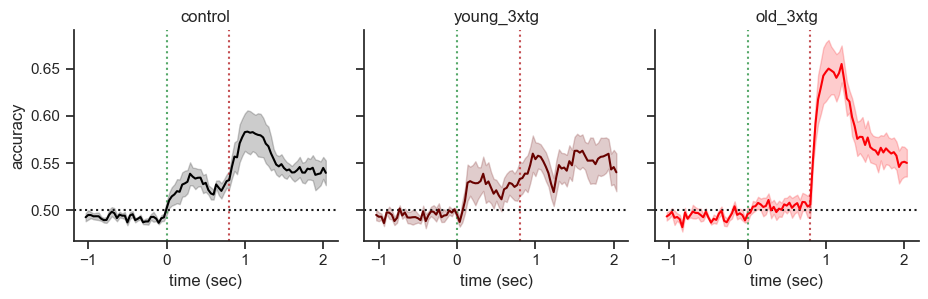

In [25]:
c_ctrl = '#000000'
c_young= '#680200'
c_old = '#FB0007'

palette = {'control': c_ctrl, 'young_3xtg': c_young, 'old_3xtg': c_old}

# Create the FacetGrid
sns.set_style("ticks")

g = sns.FacetGrid(df_all, height= 8. / 2.54, col="group", col_wrap=3, sharey=True)

# Apply the vertical lines to each subplot
def add_axlines(*args, **kwargs):
    plt.axvline(0, linestyle='dotted', color='g')
    plt.axvline(puff_rel_tone_time, linestyle='dotted', color='r')
    plt.axhline(0.5, linestyle='dotted', color='k')

g.map(add_axlines)

# Map the sns.lineplot function to each subplot
g.map_dataframe(sns.lineplot, x="time", y="accuracy", errorbar='se', hue="group", palette=palette)

g.set_titles("{col_name}")
g.set_xlabels("time (sec)")

# Adjust the layout
# g.add_legend()
plt.show()